# Cross Validating The Regression

Last week we ran a logistic regression on the team dataframe, with the numeric columns scaled and the categorical columns dummified. This week, we'll run some cross validation with regularized regressions to make sure the modelling decisions are not leading to overfitting.

First, we'll load the dataframes from the previous notebook and handle all the usual library loading.

In [6]:
%store -r teamDF
%store -r norm_teamDF
%store -r playerDF

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

from scipy import stats
from scipy.stats import skew
from scipy.stats.stats import pearsonr

### Ridge Cross Validation
***

We'll look at the root-mean squared error of with a ridge model across a range of regularization penalty parameters ($\alpha$'s).

First, we'll split up the training and test data.

**NOTE:** This data has been loaded from the previous notebook has been fully preprocessed.

In [29]:
regressors = list(set(list(norm_teamDF)) - set(['league', 'split', 'week', 'game', 'patchno', 'playerid', 'position', 'player', 'champion','result']))
X = norm_teamDF.loc[:, regressors]
y = norm_teamDF.loc[:,'result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=10)

### Ridge Cross Validation
***
To avoid repeatedly calling sklearn's `cross_val_score()` with the same arguments, I'll write a quick little function `rmse_cv()` to return the root-mean squared error across each fold.

Then, I'll build a list of the mean rmse of a ridge regression cross-validation across multiple $\alpha$'s.

In [30]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return rmse

model_ridge = Ridge()

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

### Ridge Cross Validation
***

Finally, I'll plot those rmse's across the different alpha values, to see how the size of the regularization penalty effects the score of the models.

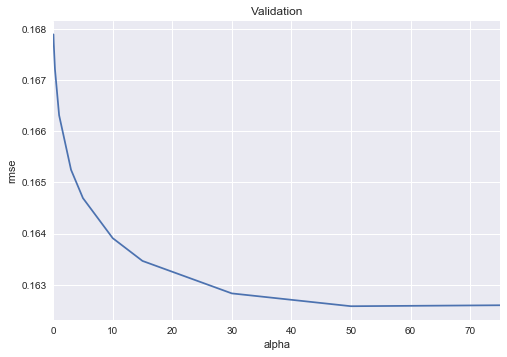

The lowest rmse for the ridge cv is:  0.162581785393


In [120]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

print('The lowest rmse for the ridge cv is: ', cv_ridge.min())

### Lasso Cross Validation
***

Next I'll run a Lasso cross validation.

In [121]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)

rmse_cv(model_lasso).mean()

0.16137505241031411

### Lasso Cross Validation
***

The rmse is comparable and slightly lower than the ridge cv.

Next, I'll examine how many features were used by the lasso model.

In [35]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 94 variables and eliminated the other 590 variables


### Lasso Cross Validation
***

That's a pretty large reduction of features. Let's examine which the model decided were the most important.

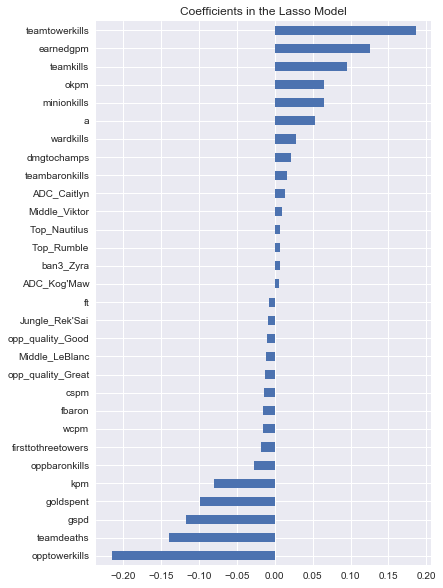

In [40]:
imp_coef = pd.concat([coef.sort_values().head(15),
                     coef.sort_values().tail(15)])

plt.figure(figsize=(6, 10))
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

### Lasso Cross Validation
***

Let's see if the residuals form any sort of pattern, or if the model is explaining as much of the variance as it can.

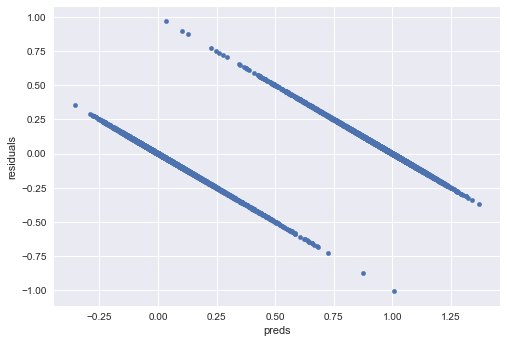

In [58]:
preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.show()

Definitely a pattern, due to the nature of the regression being performed on a categorical outcome variable. Will need to adapt this in the future.

### Lasso Across Groups
***

Now I'd like to employ the same tecnique over each patch # of the data.

In [110]:
patchDF = norm_teamDF.groupby('patchno')
patchDict = {}
rmseDict = {}

for k, df in patchDF:
    patch_X = df.loc[:, regressors]
    patch_y = df.loc[:,'result']
    
    pX_train, pX_test, py_train, py_test = train_test_split(patch_X, patch_y, test_size = .25, random_state=10)

    ml = LassoCV(alphas = [1, 0.1, 0.001]).fit(pX_train, py_train)
    
    rmseDict[k] = np.sqrt(-cross_val_score(ml, pX_train, py_train, scoring="neg_mean_squared_error", cv = 5)).mean()

    patchDict[k] = pd.Series(ml.coef_, index = pX_train.columns)

C:\Users\glander\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\glander\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\glander\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\glander\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want t

C:\Users\glander\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\glander\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\glander\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\glander\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want t

In [113]:
print(rmseDict)
print('Ranging from ', min(rmseDict.values()), ' to ', max(rmseDict.values()))

{5.2400000000000002: 0.27607721992699952, 6.0099999999999998: 0.18272371180112718, 6.0199999999999996: 0.16373732077289457, 6.0300000000000002: 0.25107340280607593, 6.04: 0.2411488928654813, 6.0499999999999998: 0.22667518017971733, 6.0599999999999996: 0.16076653125191848, 6.0700000000000003: 0.1998763711809261, 6.0800000000000001: 0.23344734139520229, 6.0999999999999996: 0.20055505175694172, 6.1100000000000003: 0.18205925342508872, 6.1200000000000001: 0.19617390496765566, 6.1299999999999999: 0.19088371800854814, 6.1399999999999997: 0.16613128272531158, 6.1500000000000004: 0.17920770117206924, 6.1600000000000001: 0.31346759804955859, 6.1799999999999997: 0.14195935646368149, 6.21: 0.22049364716219216, 7.0099999999999998: 0.22627556160731416, 7.0199999999999996: 0.15983922304356596, 7.0300000000000002: 0.23746777232678884, 7.04: 0.16707004263327663, 7.0499999999999998: 0.1756958691007931, 7.0599999999999996: 0.17087169882109721, 7.0700000000000003: 0.22544458346330862, 7.0800000000000001:

In [114]:
for k in patchDict:
    took = str(sum(patchDict[k] != 0))
    left = str(sum(patchDict[k] == 0))
    print("On patch " + str(k) + " -- " + took + " variables taken // " +  left + " dropped")

On patch 5.24 -- 6 variables taken // 678 dropped
On patch 6.01 -- 97 variables taken // 587 dropped
On patch 6.02 -- 91 variables taken // 593 dropped
On patch 6.03 -- 3 variables taken // 681 dropped
On patch 6.04 -- 2 variables taken // 682 dropped
On patch 6.05 -- 7 variables taken // 677 dropped
On patch 6.06 -- 97 variables taken // 587 dropped
On patch 6.07 -- 3 variables taken // 681 dropped
On patch 6.08 -- 7 variables taken // 677 dropped
On patch 6.1 -- 107 variables taken // 577 dropped
On patch 6.11 -- 116 variables taken // 568 dropped
On patch 6.12 -- 105 variables taken // 579 dropped
On patch 6.13 -- 114 variables taken // 570 dropped
On patch 6.14 -- 100 variables taken // 584 dropped
On patch 6.15 -- 106 variables taken // 578 dropped
On patch 6.16 -- 8 variables taken // 676 dropped
On patch 6.18 -- 68 variables taken // 616 dropped
On patch 6.21 -- 2 variables taken // 682 dropped
On patch 7.01 -- 105 variables taken // 579 dropped
On patch 7.02 -- 90 variables tak

In [118]:
for k in patchDict:
    imp_coef = pd.concat([patchDict[k].sort_values().head(), patchDict[k].sort_values().tail()])
    print(k, '\n', imp_coef[imp_coef != 0])

# plt.figure(figsize=(6, 10))
# imp_coef.plot(kind = "barh")
# plt.title("Coefficients in the Lasso Model")
# plt.show()

5.24 
 opptowerkills    -0.172364
teamdeaths       -0.035325
winRate           0.012383
kpm               0.013517
a                 0.023834
teamtowerkills    0.134470
dtype: float64
6.01 
 opptowerkills    -0.234651
goldspent        -0.187753
gspd             -0.151993
ban3_Gangplank   -0.074058
Top_Poppy        -0.069792
earnedgpm         0.085097
a                 0.097077
ban1_Olaf         0.134377
minionkills       0.148432
teamtowerkills    0.245148
dtype: float64
6.02 
 opptowerkills    -0.184253
gspd             -0.148907
Middle_Ezreal    -0.103952
Jungle_Udyr      -0.097884
visionwardbuys   -0.085409
a                 0.065223
Support_Janna     0.071780
Top_Malphite      0.071826
ban3_Nidalee      0.094909
teamtowerkills    0.254619
dtype: float64
6.03 
 opptowerkills    -0.156374
earnedgpm         0.066312
teamtowerkills    0.152483
dtype: float64
6.04 
 opptowerkills    -0.226000
teamtowerkills    0.166689
dtype: float64
6.05 
 opptowerkills    -0.129432
oppbaronkills    -0

### Bonus Testing!
***

During world's, I heard a lot of pundits rave about how the latest patch had restored balance to red side vs blue side. I wanted to see how out of balance the win rate on each side had been over the patches I had data for.

In [59]:
patch_side = teamDF.groupby(['patchno','side'])['result'].mean()
patch_side = pd.DataFrame(patch_side.unstack())
patch_side.describe()

side,Blue,Red
count,34.000000,34.000000
mean,0.564965,0.435035
std,0.054029,0.054029
min,0.475728,0.325000
25%,0.528651,0.409137
50%,0.559259,0.440741
75%,0.590863,0.471349
max,0.675000,0.524272


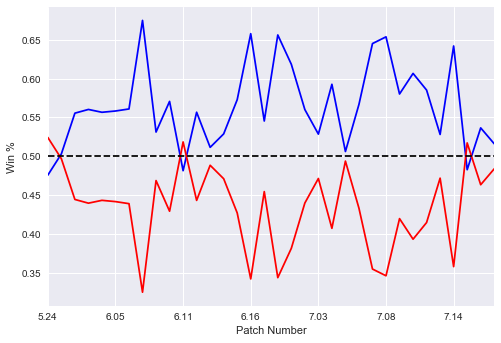

In [60]:
_ = patch_side['Blue'].plot(color = 'blue')
_ = patch_side['Red'].plot(color = 'red')
_ = plt.xlabel('Patch Number')
_ = plt.ylabel('Win %')
plt.axhline(y=.5, ls = 'dashed', color = 'black')
plt.show()

In [89]:
ps = teamDF.groupby('patchno')[['result', 'side']]
not_superior = []

print("Patches where blue side did not have a statistically significant advantage: \n")
for a, g in ps:
    blue = g[g['side'] == 'Blue']['result']
    red = g[g['side'] == 'Red']['result']
    if not stats.ttest_ind(blue, red)[1] < 0.05:
        not_superior.append(a)
        print(a)

print("For a total of ",len(not_superior),' patches out of ', len(ps))

Patches where blue side did not have a statistically significant advantage: 

5.24
6.01
6.02
6.03
6.04
6.05
6.06
6.08
6.11
6.13
6.14
6.18
7.03
7.05
7.13
7.15
7.16
7.17
For a total of  18  patches out of  34


In [16]:
numeric_feats = teamDF._get_numeric_data().columns
skewed_feats = teamDF[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats

# teamDF[skewed_feats] = np.log1p(teamDF[skewed_feats])

gamelength        0.876138
fbtime            1.454059
kpm               0.753440
okpm              0.753440
fdtime            0.763387
firedrakes        1.578233
waterdrakes       1.600988
earthdrakes       1.608500
airdrakes         1.629301
elders            2.923185
oppelders         2.923185
fbarontime        0.822723
teambaronkills    0.881502
oppbaronkills     0.881502
dmgtochamps       1.245445
wards             0.859122
wardkills         1.048908
visionwards       1.454680
visionwardbuys    0.834983
goldspent         0.937580
goldat10          0.759943
oppgoldat10       0.759943
dtype: float64

In [ ]:
# try:
#     lr = LogisticRegression(penalty='l1', solver='liblinear')
#     lr.fit(X_train, y_train)
#     pred = lr.predict(X_test)
# except Exception as ex:
#     print(ex)